<a href="https://colab.research.google.com/github/petre001/PET_Biomarkers/blob/main/main3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting PET Biomarkers of Alzheimer’s Disease With MRI Using Deep Convolutional Neural Networks 
### Contributors: Jeffrey Petrella

This project uses transfer learning to train a ResNet18 model to identify amyloid PET biomarker status from MRI images. It should be run on a GPU

### Step 1: Link Notebook to GitHub

In [4]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "PET_Biomarkers" # Enter repo name
git_path = 'https://github.com/petre001/PET_Biomarkers.git'
!git clone "{git_path}"

rm: cannot remove './sample_data': No such file or directory
Cloning into 'PET_Biomarkers'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 133 (delta 62), reused 128 (delta 61), pack-reused 3
Receiving objects: 100% (133/133), 1007.84 KiB | 8.00 MiB/s, done.
Resolving deltas: 100% (62/62), done.


### Step 2: Install and Import Dependencies

In [2]:
# Change working directory to location of notebook
# import os
# notebook_dir = ''
# path_to_notebook = os.path.join(repo_name,notebook_dir)
# path_to_notebook
%cd "{repo_name}"

/content/PET_Biomarkers


In [ ]:
# Install dependencies from requirements.txt file
!pip install -r "{'requirements.txt'}"

In [ ]:
!git clone https://github.com/Project-MONAI/MONAI.git
%cd MONAI/
!pip install -e '.[all]'

In [8]:
import os
import urllib.request
import tarfile
import zipfile
import copy
import time
import numpy as np
import pandas as pd
from torchsummary import summary
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import pydicom
import cv2
from PIL import Image

import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [9]:
import monai
from monai.data import DataLoader, ImageDataset, NumpyReader
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, EnsureType

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.12 ; cuda:  cu113


### Step 3: Load Training and Test data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd /content/drive/MyDrive/test_mci_data

/content/drive/MyDrive/test_mci_data


In [107]:
# Create a list of images and labels
df = pd.read_csv('MCI_labels.csv')
images = df.iloc[:,0].to_list()
images = [i+'.npy' for i in images]
labels = df.iloc[:,10].to_list()

In [108]:
np.size(images[171:])

21

In [109]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), RandRotate90(), EnsureType()])
val_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Create training Dataset and DataLoader using first 171 images
batch_size = 2

train_ds = ImageDataset(image_files=images[:170], labels=labels[:170], transform=train_transforms, reader='NumpyReader')
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# Create validation Dataset and DataLoader using the rest of the 21 images
val_ds = ImageDataset(image_files=images[171:], labels=labels[171:], transform=val_transforms, reader='NumpyReader')
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# Set up dict for dataloaders
dataloaders = {'train':train_loader,'val':val_loader}

# Store size of training, validation and test sets
dataset_sizes = {'train':len(train_ds),'val':len(val_ds)}

In [37]:
print("image shape:", train_ds[0][0].shape)

image shape: (1, 96, 96, 96)


In [38]:
im, label = monai.utils.misc.first(train_loader)
print(f'Image type: {type(im)}')
print(f'Input batch shape: {im.shape}')
print(f'Label batch shape: {label.shape}')

Image type: <class 'monai.data.meta_tensor.MetaTensor'>
Input batch shape: (2, 1, 96, 96, 96)
Label batch shape: torch.Size([2])


In [39]:
# Set up a mapping dictionary
classes = ['Amyloid(-)','Amyloid(+)']
idx_to_class = {i:j for i,j in enumerate(classes)}
class_to_idx = {v:k for k,v in idx_to_class.items()}

(2, 1, 96, 96, 96)
(96, 96)


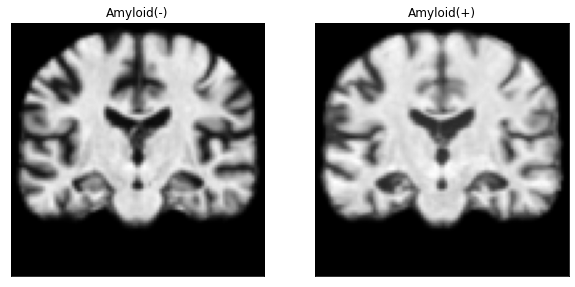

In [129]:
# Get next batch of training images
im, label = iter(train_loader).next()
print(im.shape)
im = im.numpy() # Convert images to numpy for display
label = label.numpy()
print(im[:,0,40,:,:][0].shape)
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 10))
for idx in range(batch_size):
    ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
    #ax.imshow(np.rot90(im[:,0,40,:,:][idx]), cmap='gray')
    ax.imshow(im[:,0,:,:,47][idx], cmap='gray')
    ax.set_title(idx_to_class[label[idx]])

As we see above, the 3D inputs in our DataLoader are of shape [N,C,H,W,D) where:

N = batch size
C = number of channels (1 in this case for grayscale)
H = image height
W = image width
D = image depth

###Step 4: Define our model architecture
We will used a pre-trained DenseNet 121 model for this task.

In [69]:
# Load a pre-trained DenseNet121
# We have a signle input channel, and we have 2 output classes
# We set spatial_dims=3 to indicate we want to use the version suitable for 3D input images
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)

### Step 5: Train the Model

In [83]:
def train_model(model, criterion, optimizer, dataloaders, device, num_epochs=5):

    model = model.to(device) # Send model to GPU if available

    iter_num = {'train':0,'val':0} # Track total number of iterations

    best_metric = -1

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)

                # Iterate count of iterations
                iter_num[phase] += 1

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Save weights if accuracy is best
            if phase=='val':
                if epoch_acc > best_metric:
                    best_metric = epoch_acc
                    if not os.path.exists('./models'):
                        os.mkdir('./models')
                    torch.save(model.state_dict(),'models/3d_classification_model.pth')
                    print('Saved best new model')

    print(f'Training complete. Best validation set accuracy was {best_metric}')
    
    return

In [84]:
# Use cross-entropy loss function
criterion = torch.nn.CrossEntropyLoss()
# loss_function = torch.nn.BCEWithLogitsLoss()  # also works with this data

# Use Adam adaptive optimizer
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# Train the model
epochs=5
train_model(model, criterion, optimizer, dataloaders, device, num_epochs=epochs)

Epoch 0/4
----------
train Loss: 0.6798 Acc: 0.5824
val Loss: 0.6843 Acc: 0.6667
Saved best new model
Epoch 1/4
----------
train Loss: 0.6770 Acc: 0.5882
val Loss: 0.6220 Acc: 0.6667
Epoch 2/4
----------
train Loss: 0.6849 Acc: 0.6176
val Loss: 0.6346 Acc: 0.6667
Epoch 3/4
----------
train Loss: 0.6672 Acc: 0.6118
val Loss: 0.6218 Acc: 0.6667
Epoch 4/4
----------
train Loss: 0.6760 Acc: 0.5647
val Loss: 0.5514 Acc: 0.6667
Training complete. Best validation set accuracy was 0.6666666666666666


### Step 6: Load Model and Demo Images

In [85]:
% pwd

'/content/drive/MyDrive/test_mci_data'

In [86]:
# load demo images
# Create a list of demo_images and demo_labels
df = pd.read_csv('MCI_labels.csv')
images = df.iloc[171:,0].to_list()
images = [i+'.npy' for i in images]
labels = df.iloc[:,10].to_list()

In [90]:
# load model
model2 = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
model2.load_state_dict(torch.load("models/3d_classification_model.pth"))


<All keys matched successfully>

In [161]:
# make a dataset and dataloader for demo images
# Define transforms
demo_transforms = Compose([ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), EnsureType()])

# Create demo Dataset and DataLoader
batch_size = 2
demo_ds = ImageDataset(image_files=images[171:], labels=labels[171:], transform=demo_transforms, reader='NumpyReader')
demo_loader = DataLoader(demo_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())


### Step 7: Make Predictions on Demo Images

In [156]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of demo images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        labels = labels.cpu().numpy()
        images = images.cpu().numpy() # Convert images to numpy for display
            
    print(images[:,0,40,:,:][0].shape)
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(10, 10))
    for idx in range(batch_size):
        ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
        #ax.imshow(np.rot90(im[:,0,40,:,:][idx]), cmap='gray')
        ax.imshow(images[:,0,:,:,47][idx], cmap='gray')
        #ax.set_title(idx_to_class[label[idx]])
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return


(96, 96)


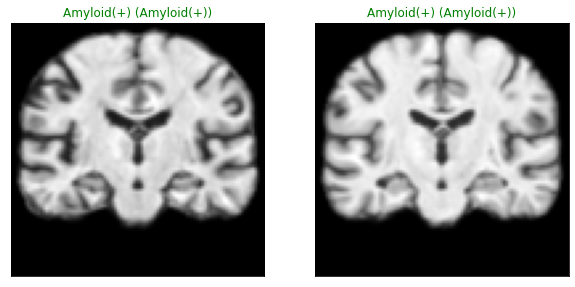

In [164]:
visualize_results(model2,demo_loader,device)

In [ ]:
 # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(10, 10))
    for idx in range(batch_size):
        ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
        #ax.imshow(np.rot90(im[:,0,40,:,:][idx]), cmap='gray')
        ax.imshow(im[:,0,:,:,47][idx], cmap='gray')
        ax.set_title(idx_to_class[label[idx]])

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image, cmap='gray')
        ax.set_title("{} ({})".format(idx_to_class[preds[idx]], idx_to_class[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
        
    return

visualize_results(model2,val_loader,device)

### Step 3: Load Model and Demo Images

This Model is a ResNet18 model that has been updated and trained with an average MAE of 5 years over 10 test sets.  

There are 10 images provided in image_data.zip for demonstration purposes: 





![](https://raw.githubusercontent.com/MRWilliamsGit/BrainAgingComputerVision/main/images/examples.png?raw=true)

In [ ]:
#unzip example images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data.zip' > /dev/null
images = [f for f in os.listdir('/content') if os.path.isfile(os.path.join('/content', f))]

In [ ]:
#get image metadata
filein = '/content/BrainAgingComputerVision/sample_data/cn_age_df.csv'
CNdata = pd.read_csv(filein)
filein = '/content/BrainAgingComputerVision/sample_data/ad_age_df.csv'
ADdata = pd.read_csv(filein)

In [ ]:
#load model
model = torch.load('/content/BrainAgingComputerVision/models/model.pt')

### Step 4: Choose Image 

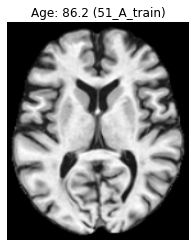

In [ ]:
#Pick one of the 10 images to see it and see its age
pick = 0

#open the image
here = os.path.join('/content/',images[pick-1])
image_3D = np.load(here)
im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
im = np.rot90(im)

#plot the image
plt.imshow(im, interpolation='nearest', cmap='gray')
imgn = images[pick-1].split(".")[0]
line = CNdata.loc[CNdata['Data ID'] == imgn]
if len(line)>0:
  label = line.iloc[0][5]
  plt.title("Age: " + str(label)+ " (" +str(imgn) +")")
  plt.axis('off');
else:
  line = ADdata.loc[ADdata['Data ID'] == imgn]
  label = line.iloc[0][5]
  plt.title("Age: " + str(label)+ "(" +str(imgn) +")")
  plt.axis('off');  


### Step 5: Get Prediction!

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#get prediction
img = (image_3D[85] * 255).astype(np.uint8)
image = SingleLoader(img)
pred = SinglePredict(model, image, device)
print("Pred: "+str(pred))

Pred: 87.5


### Step 6: AD Application

This model has been trained on cognitively normal subjects, but it interests us to see how this model would perform on subjects with degenerative brain disease such as Alzheimer's. Would the model estimate the brain to be older than it is chronologically?

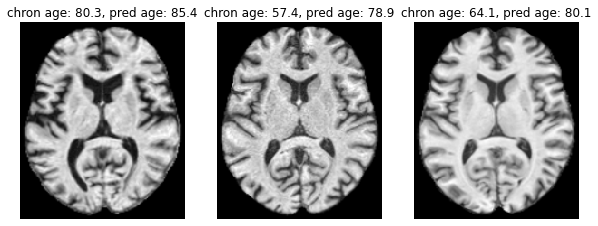

In [ ]:
#get AD images
!unzip '/content/BrainAgingComputerVision/sample_data/image_data_AD.zip' > /dev/null
images = ['2_N_test.npy', '4_T_test.npy', '7_A_test.npy']

#show them with their predictions
plt.rcParams['figure.figsize'] = [10, 5]
fig, axs = plt.subplots(1, 3)
i=0
for m in range(len(images)):
  #open the image
  here = os.path.join('/content/',images[m])
  image_3D = np.load(here)
  forpred = (image_3D[85] * 255).astype(np.uint8)
  #get prediction
  image = SingleLoader(forpred)
  pred = SinglePredict(model, image, device)
  #plot the image
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  axs[m].imshow(im, interpolation='nearest', cmap='gray')
  imgn = images[m].split(".")[0]
  line = ADdata.loc[ADdata['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[m].set_title("chron age: " + str(label) + ", pred age: " + str(pred))
  axs[m].axis('off') 
